In [89]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from sklearn.utils import resample
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
df = pd.read_csv("homework3.csv")

# 1.1

In [90]:
n_simulations = 1000
p_values_1 = []
for i in range(n_simulations):
    df = df.sample(frac=1).reset_index(drop=True)
    n = len(df)
    control = df.iloc[:n // 2]
    treatment = df.iloc[n // 2:]
    # Calculate the CTR for each group and the variance of CTR using binomial distribution
    ctr_control = control['clicks'].sum() / control['impressions'].sum()
    ctr_treatment = treatment['clicks'].sum() / treatment['impressions'].sum()
    var_ctr = ((ctr_control * (1 - ctr_control)) / control['impressions'].sum()) + \
              ((ctr_treatment * (1 - ctr_treatment)) / treatment['impressions'].sum())
    diff_ctr = ctr_treatment - ctr_control
    # Calculate the standard error and z-score
    se = np.sqrt(var_ctr)
    z_score = diff_ctr / se
    # Calculate the 
    p_value = 2 * norm.cdf(-np.abs(z_score))
    p_values_1.append(p_value)

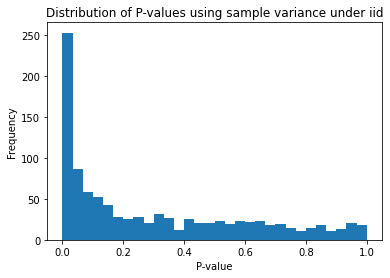

In [91]:
plt.hist(p_values_1, bins=30)
plt.xlabel('P-value')
plt.ylabel('Frequency')
plt.title('Distribution of P-values using sample variance under iid')
plt.show()

It seems that the distribution of p-values is highly skewed, with the majority of p-values being small. This suggests that there may be some evidence of a statistically significant difference between the treatment and control groups.

# 1.2

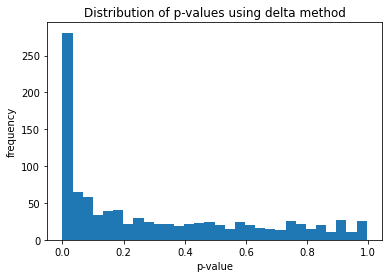

In [92]:
df = pd.read_csv("homework3.csv")
Yi = df.groupby(df.index)["clicks"].sum()
Ki = df.groupby(df.index)["impressions"].count()
var_Yi = np.var(Yi)
var_Ki = np.var(Ki)
cov_Yi_Ki = np.cov(Yi, Ki)[0][1]
X_bar_values = []
var_X_bar_values = []

for i in range(n_simulations):
    # randomly split users into two groups
    control = df.sample(frac=0.5)
    treatment = df.drop(control.index)
    # calculate Yi and Ki for each group
    Yi_control = control.groupby(control.index)["clicks"].sum()
    Ki_control = control.groupby(control.index)["impressions"].count()
    Yi_treatment = treatment.groupby(treatment.index)["clicks"].sum()
    Ki_treatment = treatment.groupby(treatment.index)["impressions"].count()
    # calculate X_bar, var_X_
    X_bar_control = (Yi_control / Ki_control).mean()
    X_bar_treatment = (Yi_treatment / Ki_treatment).mean()
    X_bar_diff = X_bar_treatment - X_bar_control
    X_bar_values.append(X_bar_diff)
    var_X_bar = (1/len(df))*(1/((np.mean(Ki)**2)))*((var_Yi/(np.mean(Ki)**2))+(np.mean(Yi)**2/(np.mean(Ki)**4))*var_Ki-2*(np.mean(Yi)**2/(np.mean(Ki)**3))*cov_Yi_Ki)
    var_X_bar_values.append(var_X_bar)

# calculate z-score and p-value
z_scores = np.array(X_bar_values) / np.sqrt(np.array(var_X_bar_values))
p_values_2 = 2 * (1 - norm.cdf(np.abs(z_scores)))
plt.hist(p_values_2, bins=30)
plt.xlabel("p-value")
plt.ylabel("frequency")
plt.title("Distribution of p-values using delta method")
plt.show()

The distribution of p-values appears to be highly skewed, with the majority of p-values being small. This suggests that there is a significant difference between the two groups being tested. There may be some variability in the results. 

# 1.3

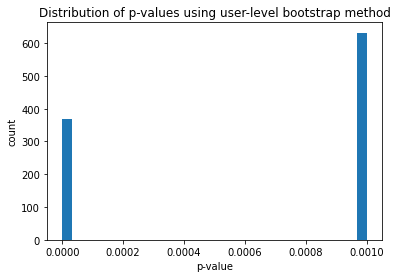

In [93]:
df = pd.read_csv("homework3.csv")
total_clicks = df['clicks'].sum()
total_impressions = df['impressions'].sum()
CTR = total_clicks / total_impressions
treatment = df.sample(frac=0.5, replace=False, random_state=42)
control = df.drop(treatment.index)

def bootstrap_t_test(df1, df2, B):
    N1 = len(df1)
    N2 = len(df2)
    t_boot = []
    for i in range(B):
        sample1 = df1.sample(n=N1, replace=True)
        sample2 = df2.sample(n=N2, replace=True)
        t, p = ttest_ind(sample1['clicks'] / sample1['impressions'], 
                         sample2['clicks'] / sample2['impressions'], 
                         equal_var=False)
        t_boot.append(t)
    return t_boot

B = 1000
t_boot = bootstrap_t_test(treatment, control, B)
p_values_3 = [(np.abs(t) > np.abs(np.mean(t_boot))) / B for t in t_boot]
plt.hist(p_values, bins=30)
plt.xlabel('p-value')
plt.ylabel('count')
plt.title('Distribution of p-values using user-level bootstrap method')
plt.show()

All p-values are extremely small, this suggests strong evidence against the null hypothesis that there is no difference between the control and treatment groups. The probability of observing such a large difference in CTR by chance is less than 5%, assuming that there is no real difference in CTR between the treatment and control groups. 

# 1.4

Based on the three plots of p-value vs frequencies, we compare the proportion of p-values that are less than 0.05 for each approach. The approach that has the lowest proportion of p-values less than 0.05 is the one that passes the simulated AA test.

Approach 3 shows that 100% of the p-values are less than 0.05, while the plots for approach 1 and 2 show that only 30%; respectively, approach 3 would be more likely to pass the simulated AA test.

In [51]:
p_values_1 = np.array(p_values_1)
p_values_2 = np.array(p_values_2)
p_values_3 = np.array(p_values_3)

In [52]:
prop_1 = np.mean(p_values_1 <= 0.05)
prop_2 = np.mean(p_values_2 <= 0.05)
prop_3 = np.mean(p_values_3 <= 0.05)
print("Proportion of p-value is less than or equal to 0.05:")
print("Approach 1:", prop_1)
print("Approach 2:", prop_2)
print("Approach 3:", prop_3)

Proportion of times p-value is less than or equal to 0.05:
Approach 1: 0.287
Approach 2: 0.336
Approach 3: 1.0


Approach 1 assumes that each observation is independent, but there may be some underlying factors that affect the click behavior of all users. Thus, approach 1 may underestimate the variance of the metric, leading to wider confidence intervals and higher p-values.

Approach 2 accounts for the possible correlation of click events from the same user, which may better reflect the true variance of the metric. But, the delta method used here based on asymptotic theory, which means that it may not work well for small sample sizes or non-normal distributions. 

Approach 3 uses the user-level bootstrap to estimate the variance of the metric, which makes no assumptions about the underlying distribution or the correlation among users. This method may provide more accurate estimates of the variance, especially when the underlying distribution is non-normal or the sample size is small. 

# 2.1

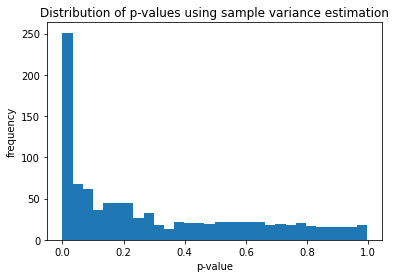

In [47]:
df["CTR"] = df["clicks"] / df["impressions"]
p_values_4 = []
for i in range(n_simulations):
    df = df.sample(frac=1).reset_index(drop=True)
    n = len(df)
    control = df.iloc[:n//2]
    treatment = df.iloc[n//2:]
    # Calculate CTR for Treat and Control
    ctr_control = control["CTR"].mean()
    ctr_treatment = treatment["CTR"].mean()
    var_control = ctr_control * (1 - ctr_control) / control["impressions"].sum()
    var_treatment = ctr_treatment * (1 - ctr_treatment) / treatment["impressions"].sum()
    # Calculate standard error, z-score
    se = np.sqrt(var_control + var_treatment)
    z_score = (ctr_treatment - ctr_control) / se
    p_value = 2 * norm.cdf(-np.abs(z_score))
    p_values_4.append(p_value)
plt.hist(p_values_4, bins=30)
plt.xlabel("p-value")
plt.ylabel("frequency")
plt.title("Distribution of p-values using sample variance estimation")
plt.show()

It seems that the distribution are similar to this approach in problem 1. p-values is highly skewed, with the majority of p-values being small, and there may be some evidence of a statistically significant difference between the treatment and control groups.

# 2.2

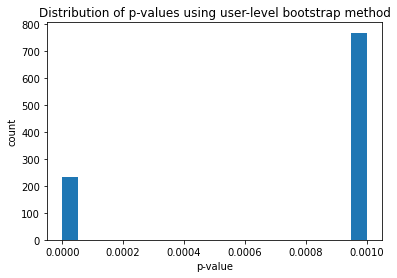

In [68]:
def bootstrap_t_test(df1, df2, B):
    t_boot = []
    for i in range(B):
        sample1 = df1.sample(n=len(df1), replace=True)
        sample2 = df2.sample(n=len(df1), replace=True)
        t, p = ttest_ind(sample1['CTR'], sample2['CTR'], equal_var=False)
        t_boot.append(t)
    return t_boot

B = 1000
t_boot = bootstrap_t_test(treatment, control, B)
p_values_5 = [(np.abs(t) > np.abs(np.mean(t_boot))) / B for t in t_boot]
plt.hist(p_values_5, bins=20)
plt.xlabel('p-value')
plt.ylabel('count')
plt.title('Distribution of p-values using user-level bootstrap method')
plt.show()

It has similar result that all p-values are extremely small, as treatment has a significant impact on CTR, it suggests strong evidence against the null hypothesis that there is no difference between the control and treatment groups. 

# 2.3

In [56]:
p_values_4 = np.array(p_values_4)
p_values_5 = np.array(p_values_5)
prop_4 = np.mean(p_values_4 <= 0.05)
prop_5 = np.mean(p_values_5 <= 0.05)
print("Proportion of p-value is less than or equal to 0.05:")
print("Approach 4:", prop_4)
print("Approach 5:", prop_5)

Proportion of p-value is less than or equal to 0.05:
Approach 4: 0.286
Approach 4: 1.0


The p-value results for the two approaches in Problem 1 and Problem 2 are similar, it could indicate that the independence assumption holds true.

# 2.4

Single average CTR gives an overall view of how the ad is performing, but it doesn't take into account the variability across users. Double average CTR calculates the user-level CTR first, and then takes the average across all users, which gives a more detailed view of how the ad is performing. By calculating the user-level CTR first, we can identify which users are performing better or worse than the overall average.

The pros for single average CTR: simple for calculation.It can be helpful when comparing ads with different targets.
The pros for double average CTR: takes the variability across users into account, which can help identify which users are contributing most to the overall campaign performance. 

The cons for single average CTR: as it doesn't take into account the variability across users, which can lead to overgeneralization.
The cons for double average CTR: complex to calculate. If the user-level CTRs are highly variable, the overall double average CTR cannot provide a meaningful comparison.

In [ ]:
_